This notebook compares lossy counting and the exact counting over the time and space efficiency as well as the accuracy infinding frequent item.

This notebook consumes **huge memory**. It consumes essentially all 32GB memory on my desktop.

Lossy counting itself is memory efficient. It would only consume around 1GB for the same task. This notebook requires huge memory only because we would like to perform exact counting to compare.

In [1]:
import sys
from collections import Counter
from tqdm import tqdm
from datasets import load_dataset
from LossyCounter import LossyCounter
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
s = 1e-6
n = 5
dataset = load_dataset("amazon_polarity")#, streaming = True)
train_set = dataset['train']

In [3]:
print("Number of reviews (million): ", len(train_set)/1e6)

Number of reviews (million):  3.6


In [4]:
eps = s/2
w = int(np.ceil(1/eps))
flush_limit = 5*w #this is also the cache size
prune_limit = 1 #prune immediately after flushing cache into counter

In [5]:
n_items_lossy = []
t0 = time.time()
ngram_count = LossyCounter(eps, flush_limit = flush_limit, prune_limit = prune_limit)
for item in tqdm(train_set):
    raw_text = item['content']
    tokens = raw_text.split(' ')
    T = len(tokens)
    ngrams = ['_'.join(tokens[i:i+n]) for i in range(T-n+1)]
    ngram_count.cache(ngrams)
    n_items_lossy.append(len(ngram_count.counter)+len(ngram_count._cache_counter))
ngram_count.flush()
ngram_count.prune()
n_items_lossy.append(len(ngram_count.counter)+len(ngram_count._cache_counter))
t1 = time.time()
dt = t1 - t0
print("total time (s): ", np.round(dt,3))

100%|██████████████████████████████| 3600000/3600000 [05:17<00:00, 11338.44it/s]


total time (s):  318.235


In [6]:
freq_keys = ngram_count.getFreqItems(s,approx = 'median')
approx_counts = ngram_count.getCounts(freq_keys, approx = 'lower')

In [7]:
print("Top 5-grams found and their counts:")
d = {k: v for k, v in sorted(approx_counts.items(), key=lambda item: item[1], reverse=True)[:10]}
for k in d:
    print(k,d[k])

Top 5-grams found and their counts:
is_one_of_the_best 14913
This_is_one_of_the 12282
If_you_are_looking_for 9830
I_would_not_recommend_this 9070
you_are_looking_for_a 8944
I_bought_this_for_my 8439
is_one_of_the_most 7341
waste_your_money_on_this 6869
at_the_end_of_the 6678
is_one_of_my_favorite 6045


In [8]:
print("Lossy Counting")
print("number of items in lossy counter: ", len(ngram_count.counter))

Lossy Counting
number of items in lossy counter:  45254


In [9]:
mem_size_lossy = sys.getsizeof(ngram_count.counter)

In [10]:
full_mem_size_lossy = mem_size_lossy + \
sum([sys.getsizeof(k)+
     sys.getsizeof(ngram_count.counter[k]) 
     for k in ngram_count.counter])

In [11]:
print("Lossy Counting")
print("memory size (hash table, MB): ", np.round(mem_size_lossy/1e6,2))

Lossy Counting
memory size (hash table, MB):  2.62


In [12]:
print("Lossy Counting")
print("memory size (all, MB): ", np.round(full_mem_size_lossy/1e6,2))

Lossy Counting
memory size (all, MB):  7.11


In [13]:
n_items_exact = []
t0 = time.time()
c = Counter()
for item in tqdm(train_set):
    raw_text = item['content']
    tokens = raw_text.split(' ')
    T = len(tokens)
    ngrams = ['_'.join(tokens[i:i+n]) for i in range(T-n+1)]
    c.update(ngrams)
    n_items_exact.append(len(c))
t1 = time.time()
dt = t1 - t0
print("total time (s): ", np.round(dt,3))

100%|██████████████████████████████| 3600000/3600000 [05:07<00:00, 11710.28it/s]

total time (s):  307.428


In [14]:
print("Exact Counting")
print("number of items in exact counter: ", len(c))

Exact Counting
number of items in exact counter:  218556227


In [15]:
mem_size_exact = sys.getsizeof(c)

In [16]:
full_mem_size_exact = mem_size_exact + \
sum([sys.getsizeof(k)+
     sys.getsizeof(c[k]) 
     for k in c])

In [17]:
print("Exact Counting")
print("memory size (hash table, MB): ", np.round(mem_size_exact/1e6,2))

Exact Counting
memory size (hash table, MB):  10737.42


In [18]:
print("Exact Counting")
print("memory size (all, MB): ", np.round(full_mem_size_exact/1e6,2))

Exact Counting
memory size (all, MB):  33456.29


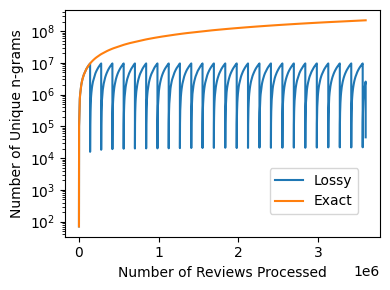

In [19]:
plt.figure(figsize=(4,3))
plt.plot(n_items_lossy)
plt.plot(n_items_exact)
plt.yscale("log")
plt.xlabel("Number of Reviews Processed")
plt.ylabel("Number of Unique n-grams")
plt.legend(["Lossy","Exact"],loc=(0.65,0.1))
plt.tight_layout()
plt.savefig("amazon_lossy_save_space.svg")
plt.savefig("amazon_lossy_save_space.pdf")

In [20]:
max(n_items_exact)/max(n_items_lossy)

22.77106742992457

In [21]:
N = c.total()
print("corpus size (5-gram, million): ", np.round(N/1e6,2))

corpus size (5-gram, million):  252.61


In [22]:
print("frequency threshold: ", int(s*N))

frequency threshold:  252


In [23]:
freq_keys = ngram_count.getFreqItems(s/10,approx = 'median')
approx_counts = ngram_count.getCounts(freq_keys, approx = 'median')

true = []
approx = []

for k in freq_keys:
    true.append(c[k]/ngram_count.total)
    approx.append(approx_counts[k]/ngram_count.total)

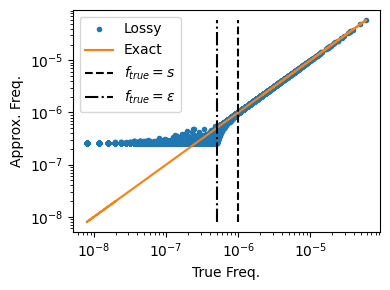

In [24]:
plt.figure(figsize=(4,3))
plt.plot(true,approx,'.')
plt.plot(true,true)
min_freq = min(true)
max_freq = max(true)
plt.plot([s,s],[min_freq,max_freq],'k--')
plt.plot([eps,eps],[min_freq,max_freq],'k-.')
plt.xscale("log")
plt.yscale("log")
plt.xlabel("True Freq.")
plt.ylabel("Approx. Freq.")
plt.legend(['Lossy','Exact','$f_{true}=s$','$f_{true}=\epsilon$'])
plt.tight_layout()
plt.savefig("amazon_lossy_correctness.svg")
plt.savefig("amazon_lossy_correctness.pdf")

In [25]:
freq_keys_approx = set(ngram_count.getFreqItems(s,approx = 'median'))
freq_keys_true = set([k for k in c if c[k]>s*N])

In [26]:
freq_keys_approx = set(ngram_count.getFreqItems(s,approx = 'median'))

In [27]:
false_alarm = freq_keys_approx.difference(freq_keys_true)
print("Lossy Counting result")
print("list of ", len(false_alarm), " false alarms and their counts")
print("out of ", len(freq_keys_true), " frequent items in total")
print("threshold: ", int(s*N))
for k in false_alarm:
    print(k,c[k])

Lossy Counting result
list of  0  false alarms and their counts
out of  4567  frequent items in total
threshold:  252


In [28]:
false_negative = freq_keys_true.difference(freq_keys_approx)
print("Lossy Counting result")
print("list of ", len(false_negative), " missed 5-grams and their counts")
print("out of ", len(freq_keys_true), " frequent items in total")
print("threshold: ", int(s*N))
for k in false_negative:
    print(k,c[k])

Lossy Counting result
list of  10  missed 5-grams and their counts
out of  4567  frequent items in total
threshold:  252
had_to_go_back_to 254
don't_know_what_else_to 254
I_love_being_able_to 256
there_was_something_wrong_with 253
If_I_had_to_do 253
are_much_better_books_out 255
I_must_say_that_it 255
I_would_give_this_a 253
highly_recommend_this_book_and 254
find_out_what_happened_to 253


In [29]:
print('The standard deviation of item count at threshold is',np.round(np.sqrt(s*(1-s)*N),2))

The standard deviation of item count at threshold is 15.89


In [30]:
del c

In [5]:
max_space = 0
#max_full_space = 0
space_lossy = []
n_items_lossy = []
ngram_count = LossyCounter(eps, flush_limit = flush_limit, prune_limit = prune_limit)
for item in tqdm(train_set):
    raw_text = item['content']
    tokens = raw_text.split(' ')
    T = len(tokens)
    ngrams = ['_'.join(tokens[i:i+n]) for i in range(T-n+1)]
    ngram_count.cache(ngrams)
    space = sys.getsizeof(ngram_count.counter) + sys.getsizeof(ngram_count._cache_counter)
    space_lossy.append(space)
    n_items = len(ngram_count.counter) + len(ngram_count._cache_counter)
    n_items_lossy.append(n_items)
    if space > max_space:
        max_space = space
    #full_space = space
    #full_space += sum([sys.getsizeof(k)+sys.getsizeof(ngram_count.counter[k]) for k in ngram_count.counter])
    #full_space += sum([sys.getsizeof(k)+sys.getsizeof(ngram_count._cache_counter[k]) for k in ngram_count._cache_counter])
    #if full_space > max_full_space:
    #    max_full_space = full_space
ngram_count.flush()
ngram_count.prune()
space = sys.getsizeof(ngram_count.counter) + sys.getsizeof(ngram_count._cache_counter)
space_lossy.append(space)
n_items = len(ngram_count.counter) + len(ngram_count._cache_counter)
n_items_lossy.append(n_items)

100%|██████████████████████████████| 3600000/3600000 [05:11<00:00, 11540.55it/s]


In [6]:
key_value_space = sum([sys.getsizeof(k)+sys.getsizeof(ngram_count.counter[k]) for k in ngram_count.counter])
avg_kv_space = key_value_space / len(ngram_count.counter)
total_space_lossy = [space_lossy[i] + n_items_lossy[i]*avg_kv_space for i in range(len(space_lossy))]

In [7]:
n_items_exact = []
space_exact = []
c = Counter()
for item in tqdm(train_set):
    raw_text = item['content']
    tokens = raw_text.split(' ')
    T = len(tokens)
    ngrams = ['_'.join(tokens[i:i+n]) for i in range(T-n+1)]
    c.update(ngrams)
    n_items_exact.append(len(c))
    space = sys.getsizeof(c)
    space_exact.append(space)

100%|██████████████████████████████| 3600000/3600000 [04:42<00:00, 12758.50it/s]


In [8]:
total_space_exact = [space_exact[i] + n_items_exact[i]*avg_kv_space for i in range(len(space_exact))]

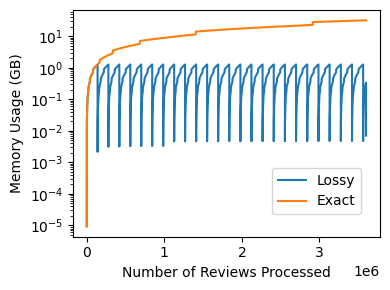

In [9]:
plt.figure(figsize=(4,3))
plt.plot([x/1e9 for x in total_space_lossy])
plt.plot([x/1e9 for x in total_space_exact])
plt.yscale("log")
plt.xlabel("Number of Reviews Processed")
plt.ylabel("Memory Usage (GB)")
plt.legend(["Lossy","Exact"],loc=(0.65,0.1))
plt.tight_layout()
plt.savefig("amazon_lossy_save_space_memory.svg")
plt.savefig("amazon_lossy_save_space_memory.pdf")

In [ ]:
print("max space for lossy counting (hash table, MB): ", np.round(max_space/1e6,2))

In [ ]:
print("lossy counting reduces memory consumption by ", np.round(mem_size_exact/max_space,2), "fold")

In [ ]:
for k in ngram_count.getFreqItems(s,approx = 'median')[:10]:
    print(k,ngram_count.counter[k])